In [218]:
import tensorflow as tf
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [219]:
input_path ="../models/"
data_path = "../dataset/data/"

In [220]:
# load test set
def load():
    print("load()")
    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    for folder in tqdm(dirs):
        (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_clean_data(folder)
        # print(f"{folder} loaded")
        
        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels)
    )

In [221]:
def load_clean_data(folder_name):
    # data
    train_data = np.load(f"{data_path}{folder_name}/train_data.npy")
    valid_data = np.load(f"{data_path}{folder_name}/valid_data.npy")
    test_data = np.load(f"{data_path}{folder_name}/test_data.npy")
    # labels
    train_labels = np.load(f"{data_path}{folder_name}/train_labels.npy")
    valid_labels = np.load(f"{data_path}{folder_name}/valid_labels.npy")
    test_labels = np.load(f"{data_path}{folder_name}/test_labels.npy")
    # return complete tuples
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))

In [222]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load()

load()


  0%|          | 0/56 [00:00<?, ?it/s]

## Choose a model

In [223]:
# chose the model to inspect
model_name = "Ultra_Chrome"
model = tf.keras.models.load_model(f"{input_path}{model_name}")        

In [224]:
test_labels = test_labels.reshape(len(test_labels),1) # needed to correctly match later

In [226]:
predictions = model.predict(test_data, verbose=1)

11545/11545 [==============================] - 84s 7ms/step


## Visualize the gene

In [227]:
def plot_gene(gene,label,prediction=False):
    gene = gene.reshape(5,100)
    df = pd.DataFrame(gene, index=['HM1','HM2','HM3','HM4','HM5'])
    plt.figure(figsize=(20, 5))
    if prediction:
        sns.heatmap(df, cmap=("RdPu" if label>=0.5 else "BuPu"))
    else:
        sns.heatmap(df, cmap=("RdPu" if label==1 else "BuPu"))
    plt.xlabel("Bins")
    plt.ylabel("Histone modifications")
    if prediction:
        print("Prediction:",label)
        plt.title("Predicted Gene expressed" if label>=0.5 else "Predicted Gene not expressed")
    else:
        plt.title("Gene expressed" if label==1 else "Gene not expressed")
    plt.show()

In [228]:
# correct predictions
# 34235, 7352, 12312, 12315

# wrong predictions
# 2, 124127, 124130, 4

x = 4

## Visualize prediction

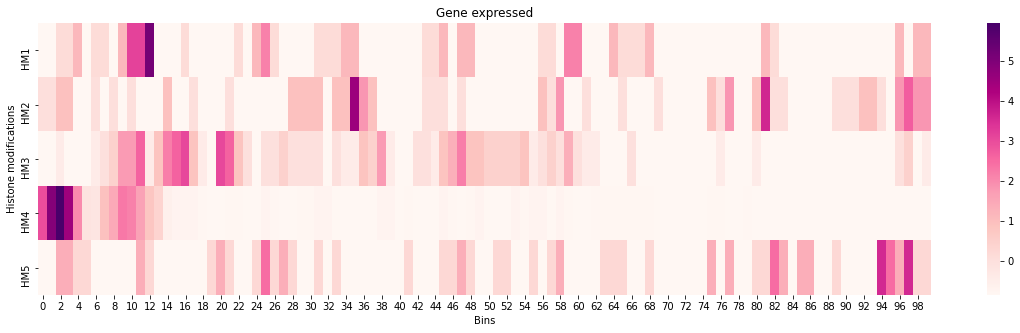

Prediction: [0.34663606]


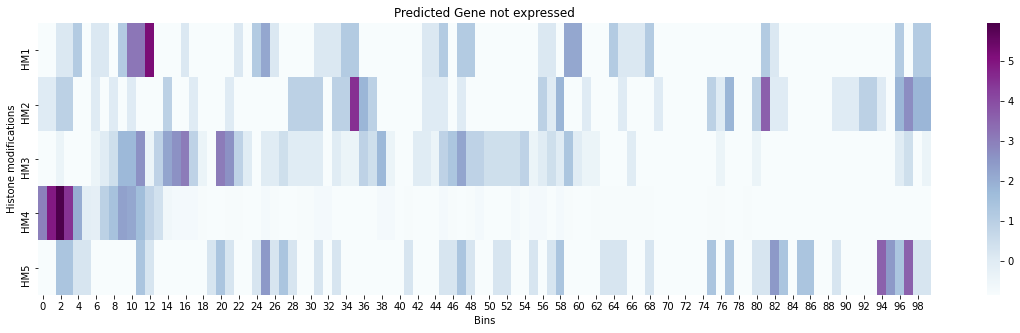

In [229]:
plot_gene(test_data[x],test_labels[x])
plot_gene(test_data[x],predictions[x],prediction=True)

## Extra considerations
> What if we want to fix a threshold ?

In [230]:
threshold = 0.5 # an example of threshold, also used for the plots

In [231]:
discrete_predictions = [0 if p<threshold else 1 for p in predictions]

In [232]:
# how many expressed genes from the total test set?
ones = []
for label in test_labels:
    if label == 1:
        ones.append(label)
print(len(ones)/len(test_labels)*100,"%") # ~23%

23.465211459754435 %


In [233]:
# with discrete values we can define a confusion matrix
cm = tf.math.confusion_matrix(test_labels.reshape(len(test_labels)),discrete_predictions,2)
print(cm)

tf.Tensor(
[[244077  38667]
 [ 40134  46554]], shape=(2, 2), dtype=int32)


### Not bad results for a fixed threshold!